In [1]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip,RandomRotation 
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import osr
import cv2
import random
from numpy import *
from PIL import Image
import tensorflow_hub as hub

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#TRAINING_DATA_DIR = "C:\\Users\\Nancy Saxena\\2\\Apple\\Train\\"
#VALIDATION_DATA_DIR = "C:\\Users\\Nancy Saxena\\2\\Apple\\Validation\\"
TRAINING_DATA_DIR = "/content/drive/MyDrive/2/Apple"
TEST_DATA_DIR = "/content/drive/MyDrive/2/test"

Mounted at /content/drive


In [3]:
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels

In [4]:
datagen_kwargs = dict(rescale=1./255, 
        validation_split=.20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

import os
os.getcwd()
collection = TRAINING_DATA_DIR
for i, filename in enumerate(os.listdir(collection)):
    os.rename(TRAINING_DATA_DIR + "\\" + filename, TRAINING_DATA_DIR  + "\\" + str(i) + ".jpg")

In [5]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='validation',
shuffle=True,
seed=24,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='training',
shuffle=True,
seed=24,
target_size=IMAGE_SHAPE)

Found 37 images belonging to 2 classes.
Found 151 images belonging to 2 classes.


In [6]:
print (train_generator.class_indices)

{'Ripe': 0, 'Unripe': 1}


In [7]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)

# Mobilenet_v2 

In [8]:
model = tf.keras.Sequential([
 hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
 train_generator, 
 epochs=10,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 0.0617 - acc: 0.9868 - val_loss: 0.0579 - val_acc: 0.9730
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 0.0346 - acc: 0.9934 - val_loss: 0.0857 - val_acc: 0.9730
Epoch 3/10
5/5 [==============================] - 15s 3s/step - loss: 0.0482 - acc: 0.9934 - val_loss: 0.1001 - val_acc: 0.9730
Epoch 4/10
5/5 [==============================] - 13s 2s/step - loss: 0.0452 - acc: 0.9934 - val_loss: 0.0822 - val_acc: 0.9459
Epoch 5/10
5/5 [==============================] - 8s 2s/step - loss: 0.0404 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9459
Epoch 6/10
5/5 [==============================] - 8s 2s/step - loss: 0.0321 - acc: 1.0000 - val_loss: 0.1271 - val_acc: 0.9189
Epoch 7/10
5/5 [==============================] - 8s 2s/step - loss: 0.0528 - acc: 0.9801 - val_loss: 0.0853 - val_acc: 0.9730
Epoch 8/10
5/5 [==============================] - 8s 2s/step - loss: 0.0329 - acc: 1.0000 - val_loss: 0.1056

In [20]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

2/2 [==============================] - 2s 140ms/step - loss: 0.0724 - acc: 0.9730
Final loss: 0.07
Final accuracy: 97.30%


In [21]:
model.save_weights(filepath='final_weight_mboilenet.h5')

In [22]:
model.save('mobilenetv2')

INFO:tensorflow:Assets written to: mobilenetv2/assets


INFO:tensorflow:Assets written to: mobilenetv2/assets


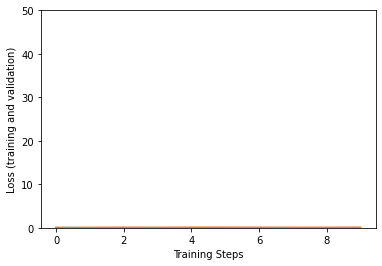

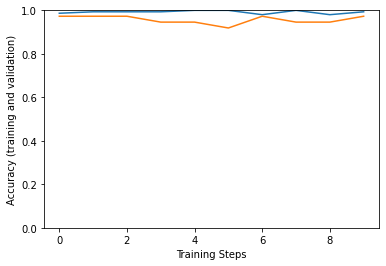

In [23]:
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,50])
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

In [24]:
import os
image_names=os.listdir(TEST_DATA_DIR)
print(image_names)
for filename in image_names:
    img = cv2.imread(os.path.join(TEST_DATA_DIR,filename))    
   # img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    img=cv2.resize(img,(224,224))
    x=np.expand_dims(img, axis=0)
    images = np.vstack([x]) 
    classes = model.predict(images, batch_size=10)
    output_class=np.argmax(classes)
    if (output_class==0):
        output_class='Ripe'
    else:
        output_class='Unripe'
    score = tf.nn.softmax(classes[0])
    print(
    
    "The image is {} This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(filename,output_class, 100 * np.max(score))
    )

['2.png', '7.png', '5.png', '3.png', '8.png', '10.png', '9.png', '1.png', '6.png', '4.jpg']
The image is 2.png This image most likely belongs to Ripe with a 58.64 percent confidence.
The image is 7.png This image most likely belongs to Unripe with a 54.22 percent confidence.
The image is 5.png This image most likely belongs to Unripe with a 55.62 percent confidence.
The image is 3.png This image most likely belongs to Unripe with a 63.57 percent confidence.
The image is 8.png This image most likely belongs to Ripe with a 51.58 percent confidence.
The image is 10.png This image most likely belongs to Unripe with a 59.75 percent confidence.
The image is 9.png This image most likely belongs to Unripe with a 61.05 percent confidence.
The image is 1.png This image most likely belongs to Ripe with a 53.49 percent confidence.
The image is 6.png This image most likely belongs to Unripe with a 66.42 percent confidence.
The image is 4.jpg This image most likely belongs to Ripe with a 56.94 perce

# CNN

In [25]:
model_cnn= Sequential([

    Conv2D(input_shape=(224,224,3), filters=6, kernel_size=5, strides=1,padding='same',activation=tf.nn.relu),

    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(16, kernel_size=5, strides=1, padding='same', activation=tf.nn.relu),

    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    Dense(120, activation=tf.nn.relu),

    Dense(2, activation=tf.nn.softmax)

])

In [26]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model_cnn.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense_1 (Dense)             (None, 120)              

In [28]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model_cnn.fit(
 train_generator, 
 epochs=10,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

Epoch 1/10
5/5 [==============================] - 12s 2s/step - loss: 15.7256 - acc: 0.5099 - val_loss: 12.3548 - val_acc: 0.5405
Epoch 2/10
5/5 [==============================] - 11s 2s/step - loss: 6.2018 - acc: 0.5364 - val_loss: 0.7238 - val_acc: 0.5405
Epoch 3/10
5/5 [==============================] - 12s 2s/step - loss: 0.7908 - acc: 0.4901 - val_loss: 0.5087 - val_acc: 0.7838
Epoch 4/10
5/5 [==============================] - 11s 2s/step - loss: 0.5294 - acc: 0.6225 - val_loss: 0.4500 - val_acc: 0.6216
Epoch 5/10
5/5 [==============================] - 11s 2s/step - loss: 0.4784 - acc: 0.6954 - val_loss: 0.3889 - val_acc: 0.8919
Epoch 6/10
5/5 [==============================] - 11s 2s/step - loss: 0.4668 - acc: 0.8411 - val_loss: 0.4099 - val_acc: 0.9189
Epoch 7/10
5/5 [==============================] - 11s 2s/step - loss: 0.4518 - acc: 0.8411 - val_loss: 0.4079 - val_acc: 0.9189
Epoch 8/10
5/5 [==============================] - 11s 2s/step - loss: 0.4250 - acc: 0.8609 - val_loss:

In [29]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

2/2 [==============================] - 2s 161ms/step - loss: 0.0686 - acc: 0.9730
Final loss: 0.07
Final accuracy: 97.30%


In [30]:
image_names=os.listdir(TEST_DATA_DIR)
print(image_names)
for filename in image_names:
    img = cv2.imread(os.path.join(TEST_DATA_DIR,filename))    
    #img = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
    img=cv2.resize(img,(224,224))
    x=np.expand_dims(img, axis=0)
    images = np.vstack([x]) 
    classes = model.predict(images, batch_size=10)
    output_class=np.argmax(classes)
    if (output_class==0):
        output_class='Ripe'
    else:
        output_class='Unripe'
    score = tf.nn.softmax(classes[0])
    print(
    
    "The image is {} This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(filename,output_class, 100 * np.max(score))
    )

['2.png', '7.png', '5.png', '3.png', '8.png', '10.png', '9.png', '1.png', '6.png', '4.jpg']
The image is 2.png This image most likely belongs to Ripe with a 58.64 percent confidence.
The image is 7.png This image most likely belongs to Unripe with a 54.22 percent confidence.
The image is 5.png This image most likely belongs to Unripe with a 55.62 percent confidence.
The image is 3.png This image most likely belongs to Unripe with a 63.57 percent confidence.
The image is 8.png This image most likely belongs to Ripe with a 51.58 percent confidence.
The image is 10.png This image most likely belongs to Unripe with a 59.75 percent confidence.
The image is 9.png This image most likely belongs to Unripe with a 61.05 percent confidence.
The image is 1.png This image most likely belongs to Ripe with a 53.49 percent confidence.
The image is 6.png This image most likely belongs to Unripe with a 66.42 percent confidence.
The image is 4.jpg This image most likely belongs to Ripe with a 56.94 perce

In [31]:
model_cnn.save_weights(filepath='final_weight_cnn.h5')

In [32]:
model_cnn.save('CNN')

INFO:tensorflow:Assets written to: CNN/assets


INFO:tensorflow:Assets written to: CNN/assets


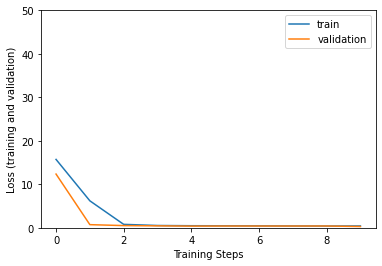

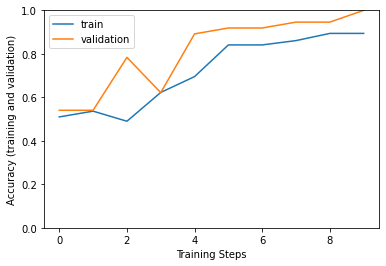

In [95]:
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,50])
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(['train', 'validation'])
plt.show()
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.legend(['train', 'validation'])
plt.show()

# EffecientNet B0



In [72]:

EfficientNetB0_model = Sequential()

pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2,
    classifier_activation="softmax")


for layer in pretrained_model.layers:
        layer.trainable=False

16719872/16705208 [==============================] - 0s 0us/step


In [73]:
EfficientNetB0_model.add(pretrained_model)
EfficientNetB0_model.add(Flatten())
EfficientNetB0_model.add(Dense(512, activation='relu'))
EfficientNetB0_model.add(Dense(2, activation='softmax'))

In [75]:

EfficientNetB0_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               655872    
                                                                 
 dense_10 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 4,706,469
Trainable params: 656,898
Non-trainable params: 4,049,571
_________________________________________________________________


In [83]:
EfficientNetB0_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])


In [84]:
epochs=100

history = EfficientNetB0_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100
)

Epoch 1/100
5/5 [==============================] - 50s 3s/step - loss: 0.7002 - accuracy: 0.5364 - val_loss: 0.6879 - val_accuracy: 0.5405
Epoch 2/100
5/5 [==============================] - 12s 2s/step - loss: 0.6863 - accuracy: 0.5364 - val_loss: 0.6894 - val_accuracy: 0.5405
Epoch 3/100
5/5 [==============================] - 12s 2s/step - loss: 0.6947 - accuracy: 0.4901 - val_loss: 0.6903 - val_accuracy: 0.5405
Epoch 4/100
5/5 [==============================] - 12s 2s/step - loss: 0.7001 - accuracy: 0.4901 - val_loss: 0.6900 - val_accuracy: 0.5405
Epoch 5/100
5/5 [==============================] - 12s 2s/step - loss: 0.6918 - accuracy: 0.5166 - val_loss: 0.6896 - val_accuracy: 0.5405
Epoch 6/100
5/5 [==============================] - 12s 2s/step - loss: 0.6938 - accuracy: 0.4967 - val_loss: 0.6883 - val_accuracy: 0.5405
Epoch 7/100
5/5 [==============================] - 12s 2s/step - loss: 0.6870 - accuracy: 0.5364 - val_loss: 0.6881 - val_accuracy: 0.5405
Epoch 8/100
5/5 [==========

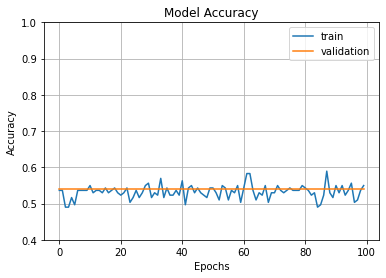

In [85]:
  # Model Evaluation

  fig1 = plt.gcf()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.axis(ymin=0.4,ymax=1)
  plt.grid()
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])
  plt.show()

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predicted_categories = np.argmax(EfficientNetB4_model.predict(x), axis = 1)
  predictions = np.concatenate([predictions, predicted_categories])
  labels = np.concatenate([labels, y.numpy()], axis=0)

tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [ ]:
print(classification_report(labels, predictions, target_names=classnames))